# Baseline V2 실험 결과 분석
- 동일한 아키텍처, 세팅은 다른 실험들을 각각 분석

## exp, exp2, exp3

```python
# Config
{
    "seed": 42, # random_seed
    "epochs": 1 -> 10 -> 20, # num_epochs
    "dataset": "MaskBaseDataset", # dataset
    "augmentation": "BaseAugmentation", # augmentation_method
    "resize": [
        128,
        96
    ],
    "batch_size": 64, # num_batch_size
    "valid_batch_size": 1000, # max_batch_size
    "model": "BaseModel", # select model
    "optimizer": "SGD", # select optimizer
    "lr": 0.001, # select learning rate
    "val_ratio": 0.2, # select train/val split
    "criterion": "cross_entropy", # select objective function
    "lr_decay_step": 20, # steps for lr decay
    "log_interval": 20, # ?
    "name": "exp", "exp2", "exp3",
}
```

In [23]:
from IPython.display import Image

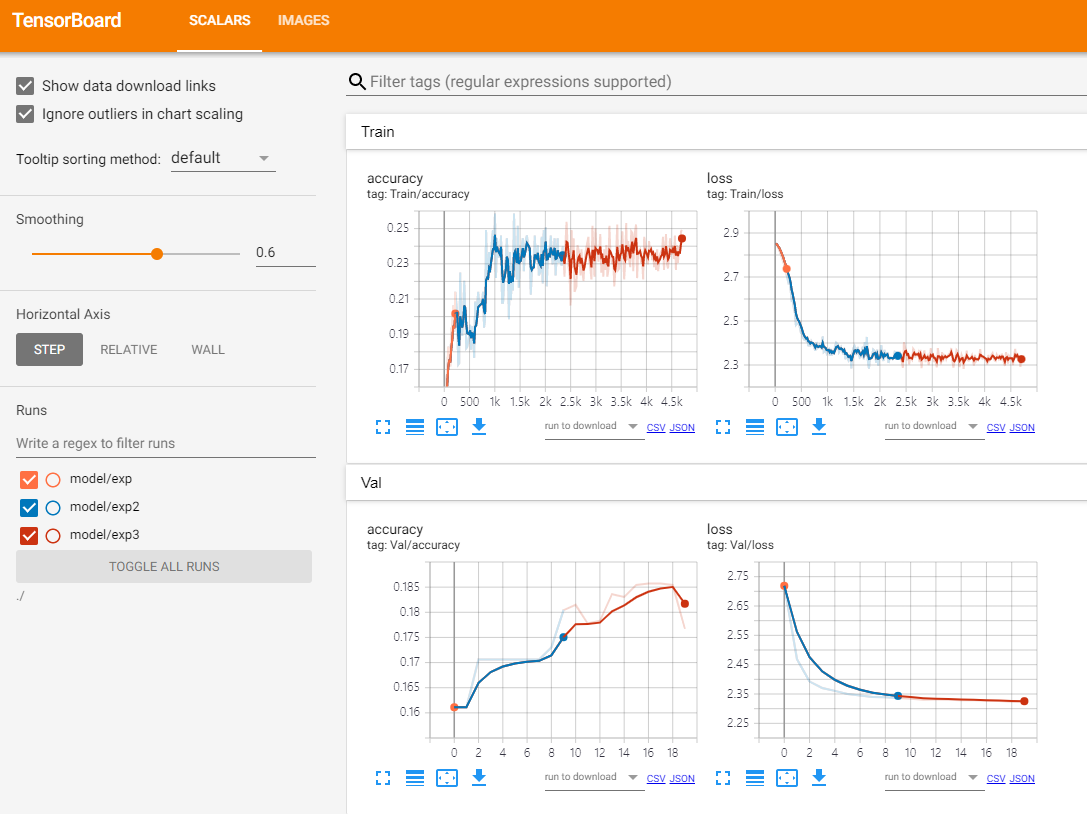

In [12]:
# PNG 파일을 불러와서 표시합니다.
Image(filename='/opt/ml/base_code/results/v2_per_epoch.PNG')

**[결과]**
- epoch을 1 -> 10 -> 20으로 변경해서 테스트했는데, 큰 성능 차이는 없었다.

**[분석]**
- v2는 v1에 비해 사용성이 증가했을 뿐, 모델 구조의 차이는 없다.
- dataset, augmentation, optimizer, criterion에 대한 utility가 추가되었다.

**[계획]**
- optimizer를 SGD에서 Adam으로 바꾼 뒤 실험해볼 생각이다.
    - 일반적으로 Adam이 SGD보다 수렴 속도가 훨씬 빠르면서 잘 된다고 알려져있다.
- epoch은 1, 10, 20에 대해 모두 테스트하기 보다는, 10 epoch으로 고정하고 테스트해볼 생각이다.
    - 1 epoch은 너무 작고, 10 epoch과 20 epoch은 epoch 길이에 따른 성능 차이는 없어서 10 epoch으로 세팅한다.

# exp4, exp5

```python
# Config
{
    "seed": 42,
    "epochs": 10 -> 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        128,
        96
    ],
    "batch_size": 64,
    "valid_batch_size": 1000,
    "model": "BaseModel",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "exp4 ", "exp5"
}
```

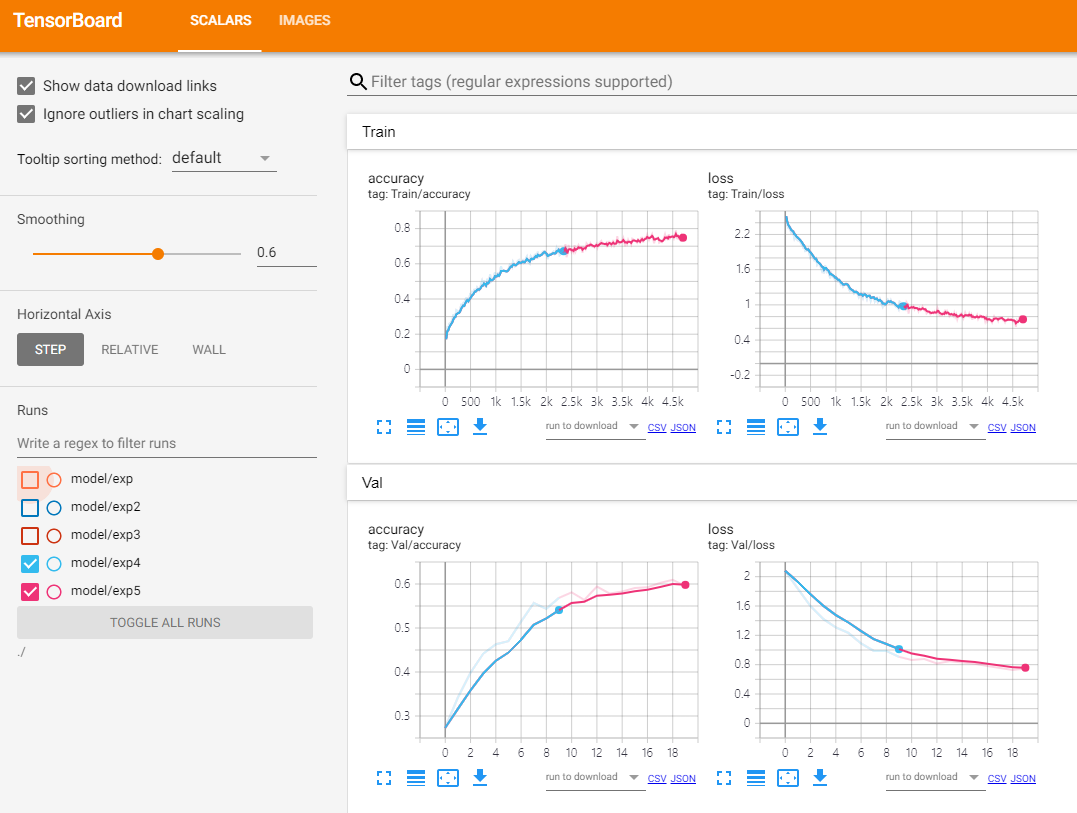

In [13]:
Image(filename='/opt/ml/base_code/results/v2_sgd_to_adam.PNG')

**[결과]**
- Epoch이 10인 상태에서 optimizer를 sgd -> adam으로 변경했을 때 성능이 대폭 상승했다.
- Adam optimizer를 사용하면서, epoch을 10 -> 20으로 변경했을 때 성능이 소폭 상승했다.

**[분석]**
- Adam은 계산한 gradient를 다양하게 활용하여 최적화하기 때문에, sgd보다 훨씬 빠르면서 안정적이게 수렴하는 것으로 보인다. (optimizer만 바꿨는데도 성능 차이가 엄청난 것이 놀라웠다.)
- Epoch에 따른 성능 차이는 크지 않았는데, 아무래도 아키텍처가 단순하기 때문에 epoch이 부족해서 최적화가 덜 되거나 하는 현상은 발생하지 않는 것으로 생각한다.
다만 소폭이더라도 성능이 향상됐기 때문에, 이후 실험은 epoch을 20으로 세팅하는 것이 좋아보인다.

**[계획]**
- Epoch에 따른 성능 차이는 없을 것으로 예상하기 때문에, v2에서 제공되는 다른 augmentation 기법을 적용해서 실험한다.

# exp6

```python
# config
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "CustomAugmentation", # BaseAugmentation -> CustomAugmentation
    "resize": [
        128,
        96
    ],
    "batch_size": 64,
    "valid_batch_size": 1000,
    "model": "BaseModel",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "exp6",
}
```

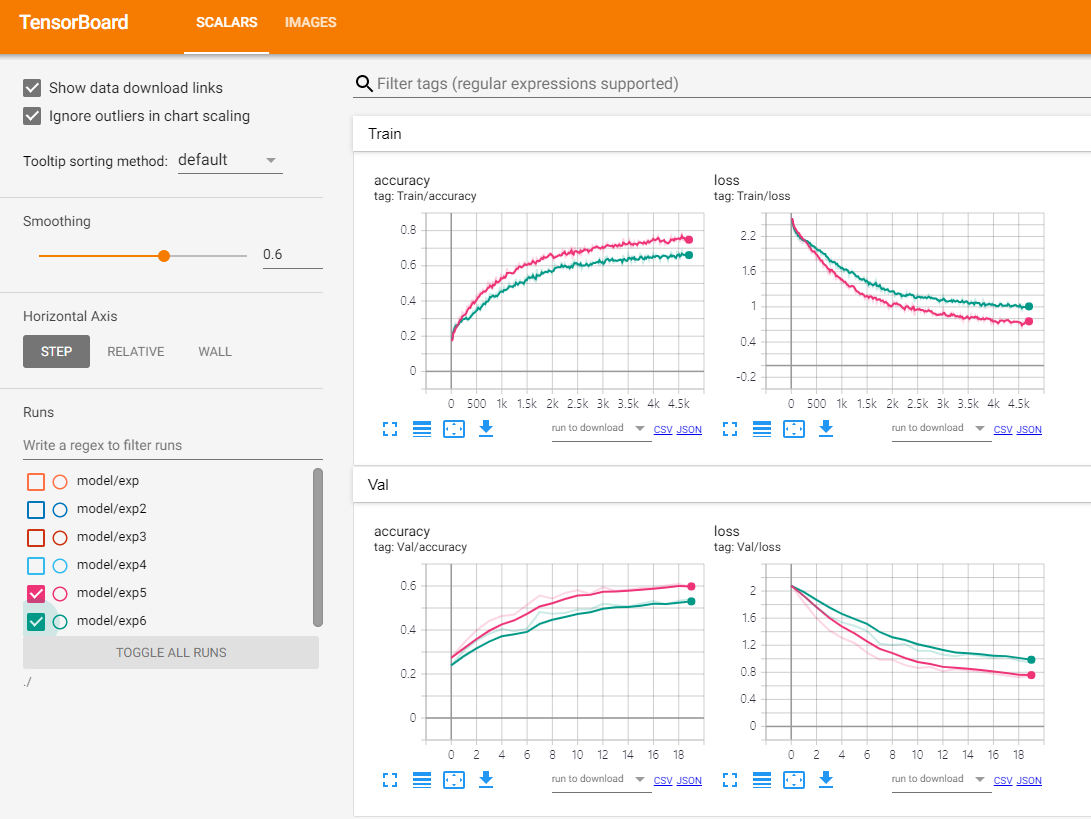

In [14]:
Image(filename="/opt/ml/base_code/results/v2_baseaugment_to_customaugment.PNG")

**[결과]**
- Epoch이 20인 상태에서 BaseAugment -> CustomAugment로 변경했을 때 성능이 떨어졌다.

**[분석]**
- 성능이 떨어진 이유를 분석하려면, 우선 CustomAugment가 어떻게 구성되어있는지 확인해야 한다(제공된 코드에서 변경한 것 없음).
```python
self.transform = Compose([
            CenterCrop((320, 256)), # CenterCrop: 이미지에서 불필요한 배경을 제거하기 위해 적용한 것으로 보인다.
            Resize(resize, Image.BILINEAR), # Resize: 모델에 입력해주기 위해 Resize
            ColorJitter(0.1, 0.1, 0.1, 0.1), # ColorJitter: 이미지의 색상을 다양하게 변경해본 것 같은데,, 대충 생각해보았을 때 필요할 것 같지는 않다.
            ToTensor(), # ToTensor(): PIL 혹은 np.array를 tensor로 변경
            Normalize(mean=mean, std=std), # Normalize: 안정적인 학습을 위해 scaling한 것
            AddGaussianNoise() # AddGaussianNoise: 이미지에 가우시안 노이즈를 더해주는 건데,, 이것도 딱히 필요없을 것 같다.
        ])
```
- ColorJitter와 AddGaussianNoise의 효용성에 대해 찾아보고 분석하기

**[계획]**
- CustomAugment에서 ColorJitter와 AddGaussianNoise를 빼고 실험해볼 생각이다.

# exp7

```python
# config
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "CustomAugmentation", # BaseAugmentation + CenterCrop
    "resize": [
        128,
        96
    ],
    "batch_size": 64,
    "valid_batch_size": 1000,
    "model": "BaseModel",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "exp7",
}
```

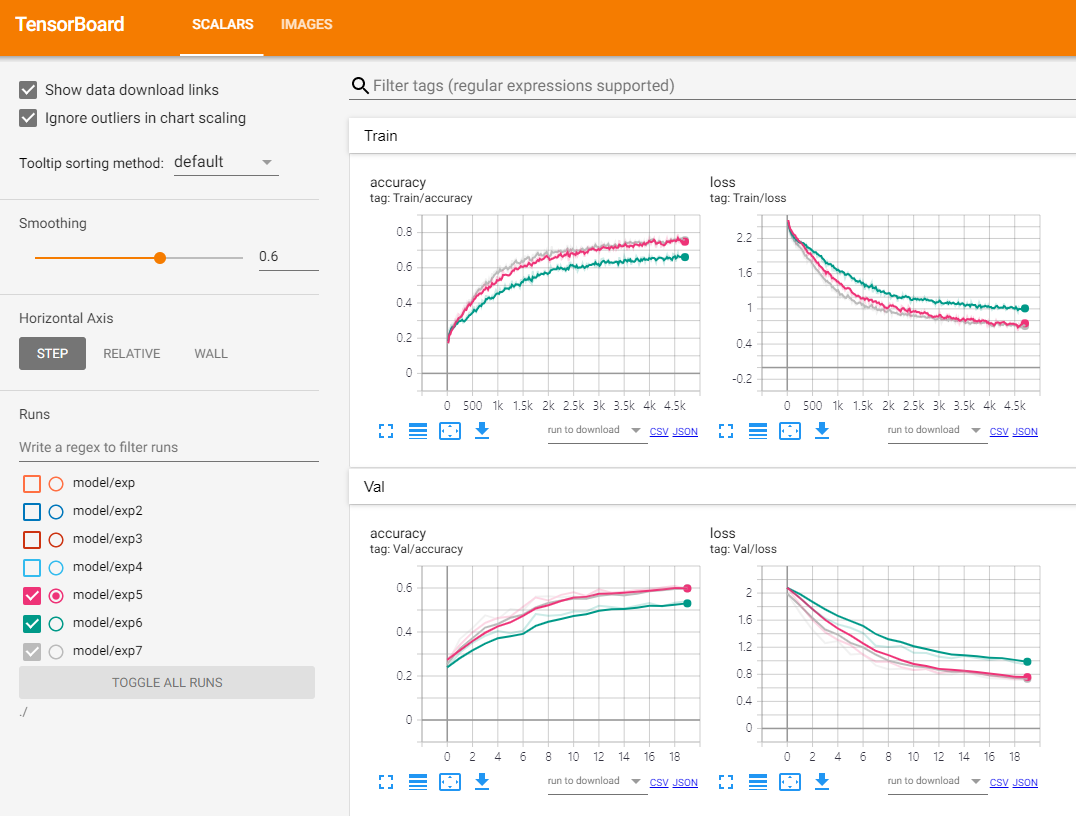

In [15]:
Image(filename="/opt/ml/base_code/results/v2_only_centercrop.PNG")

**[결과]**
- 비교군: exp5, exp6, exp7
- Epoch이 20인 상태에서 BaseAugment / CustomAugment / BaseAugment + CenterCrop을 비교했다.
- CenterCrop을 적용했을 때 BaseAugment와 비교해서 성능이 아주 소폭 올라갔다.

**[분석]**
- 성능 차이가 나지 않았던 점이 이미지 속 인물이 해당 위치에 없었기 때문인지, 혹은 다른 요인 때문인지 분석이 어렵다.

**[계획]**
- EDA를 통해 CenterCrop의 효용성을 체크해보아야 한다.
- 피어세션을 통해 batch_size를 변경했을 때 성능이 더 올라가는 것 같아서, batch_size를 절반으로 줄인 상태에서 학습을 시켜볼 생각이다.
- 또한 현재 loss가 cross entropy loss라서, focal loss나 f1 loss를 사용해볼 생각이다. (focal loss를 사용했을 때 error가 발생한다고 하는데, 실제 돌려보고 체크해야한다.)

# exp 8

```python
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        128,
        96
    ],
    "batch_size": 32, # exp 5에서 batch size를 절반으로 줄인 것
    "valid_batch_size": 1000,
    "model": "BaseModel",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "exp",
    "data_dir": "/opt/ml/input/data/train/images",
    "model_dir": "./model"
}
```

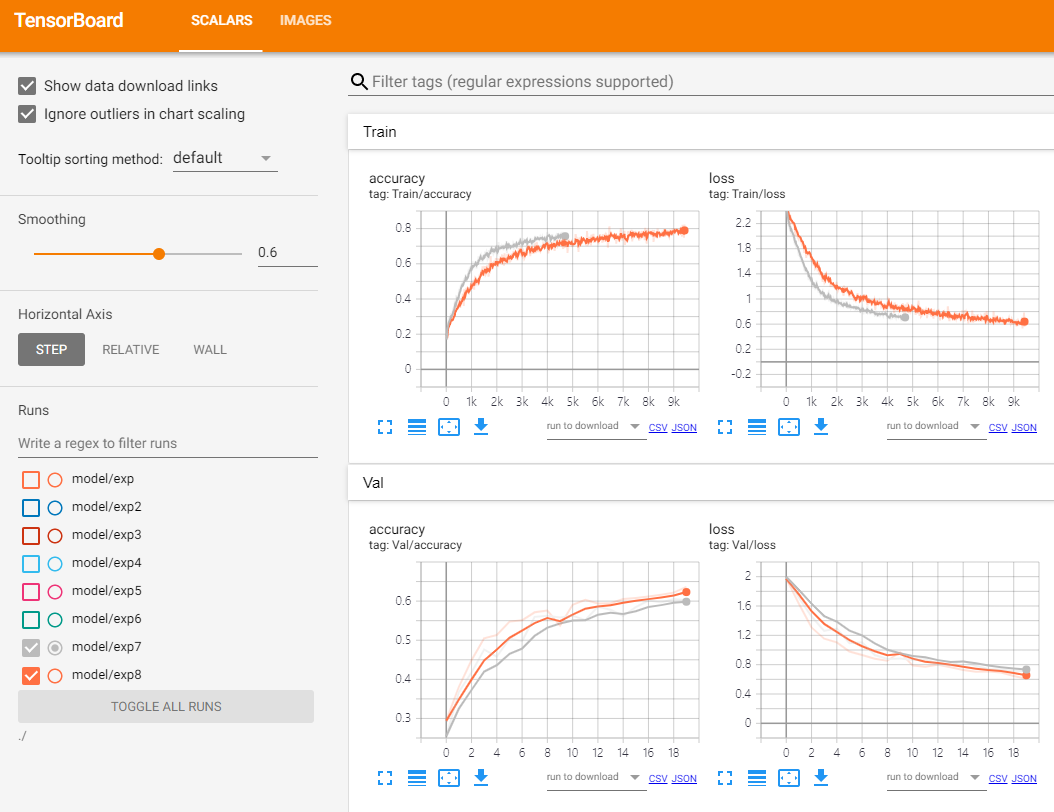

In [16]:
Image(filename="/opt/ml/base_code/results/v2_exp8_reduce_batchsize.PNG")

**[결과]**
- 비교군: exp7, exp8
- Epoch이 20인 상태에서 Batch_size를 64 -> 32로 변경한 뒤 실험했다.
- Validation 기준 3% 정도 정확도가 올라갔다.
- exp7이랑 exp8이랑 train 그래프 길이가 다른 이유는, logging 단위 때문에 그렇다. 실제로는 똑같은 epoch만큼 학습했다.

**[분석]**
- 데이터의 총량이 많지 않아서, batch size가 너무 크면 update 횟수가 부족할 수 있다.
- 데이터의 양이 같을 때, batch_size를 키우고 epoch을 늘리는 게 좋을까? 아니면 batch size를 줄이고 epoch도 줄이는 게 좋을까?
-> 데이터셋의 imbalance가 심하기 때문에, batch_size를 키우고 batch당 update를 하게 되면 오히려 성능이 좋지 않을 것 같다.
-> batch_size를 줄였을 때 성능이 좋았던 점도 이 때문이 아닐까 싶다.

**[계획]**
- 중반 단계부터 성능 향상이 미미한 것 같아가지고, exp8에서 lr_decay_step을 20 -> 10으로 줄여볼까 싶다.

# exp9

```python
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        128,
        96
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "BaseModel",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 10, # 20 -> 10
    "log_interval": 20,
    "name": "exp9",
}
```

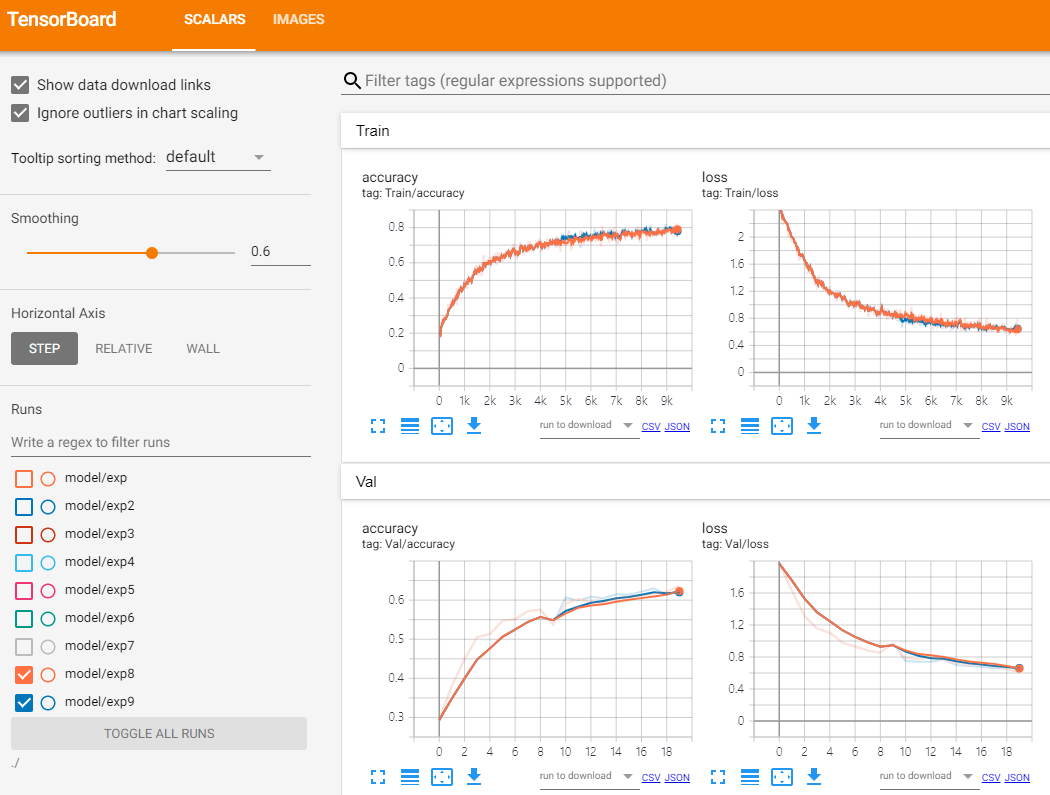

In [17]:
Image(filename="/opt/ml/base_code/results/v2_exp9_reduce_lr_decay_step.PNG")

**[결과]**
- 비교군: exp8, exp9
- lr_decay_step을 20 -> 10으로 변경했다.
- Validation 기준 0.6% 정도 정확도가 떨어졌다.

**[분석]**
- epoch이 적은 상황에서 lr을 decay하는 것이 성능에 큰 영향을 주지는 않는 것 같다.
- 다만 다른 parameter들이 결정된 상황이라면, lr_scheduler를 사용해보는 것도 좋아보인다.

**[계획]**
- 마지막으로 exp8 기준으로 cross-entropy loss가 아닌 focal loss, label_smoothing loss, f1 loss등을 사용해볼 생각이다.

# exp9, 10

```python
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        128,
        96
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "BaseModel",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "focal_with_gamma=2",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "exp10", "exp11"
}
```

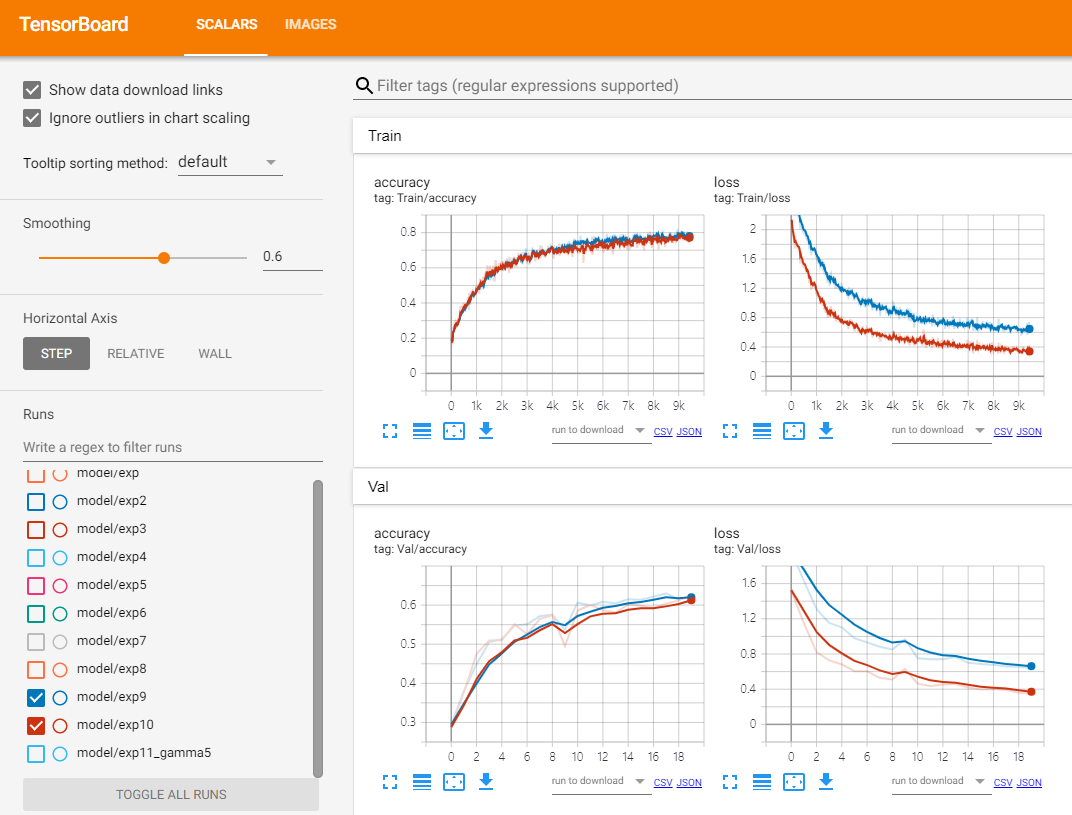

In [18]:
Image(filename="/opt/ml/base_code/results/v2_exp10_focal_gamma_2.PNG")

**[변경사항]**
- 비교군: exp9, exp10
- cross entropy loss에서 focal loss(gamma=2)로 변경하였음.

**[결과]**
- Accuracy 측면에서는 큰 차이가 없었으나, loss의 경우 cross-entropy loss보다 낮게 측정되었음.
- focal loss의 경우, CE와 비교했을 때 학습 초기 accuracy가 보다 큰 폭으로 상승하였으나, epoch이 길어질수록 saturation되는 현상이 보였음.

**[분석]**
- 정확한 원인 분석은 어렵지만,, 아무래도 모델이 너무 단순하다보니, 초기 상승폭에 비해 성능이 나오지 않은 것 같음.
- 아키텍처를 변경한다면 CE보다 focal loss를 사용하는 것이 성능 측면에서 더 좋을 것으로 예상함

**[계획]**
- focal loss는 class imbalance 문제를 해결하기 위해 사용하는데, parameter로는 gamma가 존재함.
- gamma가 커질수록 오분류된 클래스에 대한 gradient 값이 커져서 더 많이 update가 됨.
- data 자체에 class imbalance 문제가 심하므로(mask, sex, age), gamma값을 키워서 학습시켜볼 계획.

# exp 10, 11

```python
# config
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        128,
        96
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "BaseModel",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "focal", # gamma=5
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "exp11_gamma5",
}
```

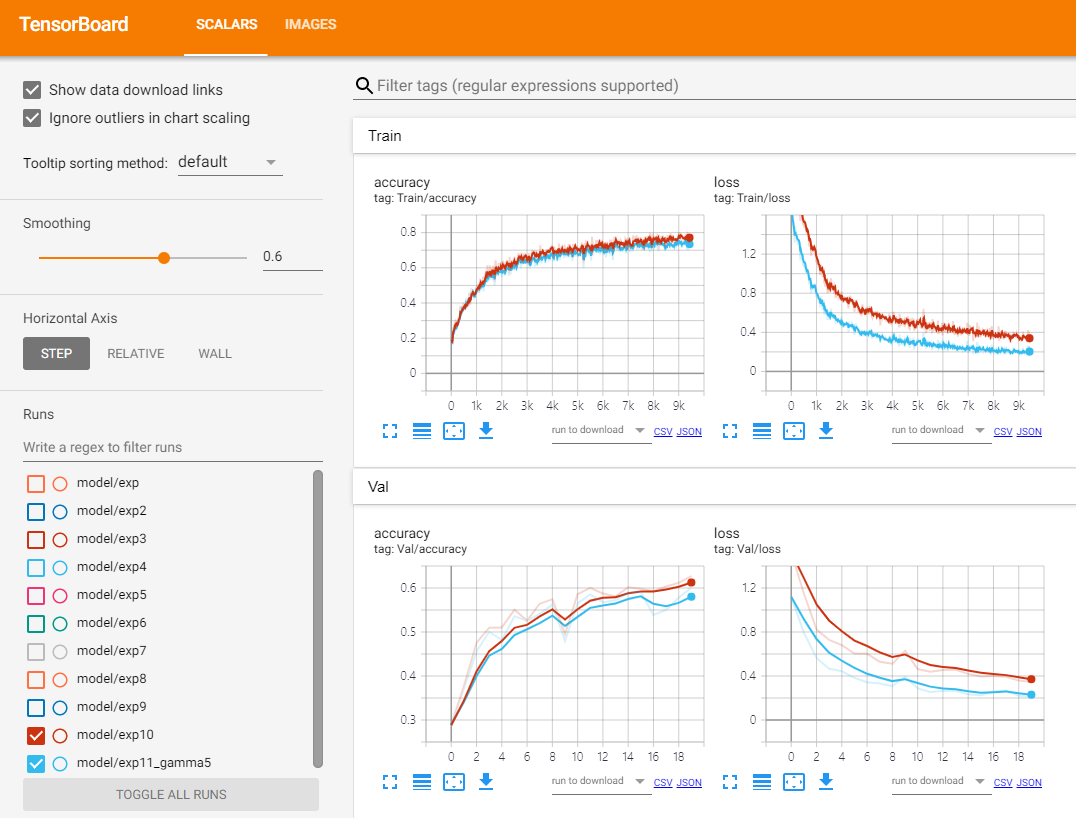

In [19]:
Image(filename="/opt/ml/base_code/results/v2_exp11_focal_gamma_5.PNG")

**[변경사항]**
- 비교군: exp10, exp11
- focal loss의 gamma를 2에서 5로 변경하였음.

**[결과]**
- gamma가 2일 때에 비해 성능이 떨어졌음.

**[분석]**
- focal loss를 사용할 때 계속해서 관측되는 현상이, accuracy 측면에서는 성능 향상이 없는데 loss는 더 낮음.
- 이걸 overfitting이라고 해석하기는 무리가 있는 것 같다(아무래도 train/val loss가 계속해서 떨어지고 있고, acc 또한 상승하기는 하므로).
- loss가 낮은 이유에 대해 생각해보았는데, 낮을 수 밖에 없었음.
    - focal loss는 gradient 관점에서 만들어진 loss이기 때문에, 미분값이 아닌 출력값의 경우 gamma를 크게 줄 수록 CE보다 전체적으로 loss가 낮아짐.
    - 이는 focal loss의 형태를 보면 알 수 있음.

**[계획]**
- inference 코드를 보다가 알게된 건데, 입력 이미지의 크기를 (512, 384)로 resize해서 넣어주고 있었음.
- 현재 모든 실험은 입력을 (128, 96)으로 resize한 뒤 학습시키는데, 원본 데이터를 작게 만들어서 넣어줄 이유가 없다고 생각함.
- 현재 실험했던 모델 중 가장 높은 validation acc를 보인 exp8 setting을 기준으로, img size를 원본 그대로 넣어준 뒤에 학습시켜볼 계획

In [20]:
from PIL import Image

img = Image.open('/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg')
print(img.size)

(384, 512)


# exp12

```python
# Config
{
    "seed": 42,
    "epochs": 20,
    "dataset": "MaskBaseDataset",
    "augmentation": "BaseAugmentation",
    "resize": [
        256,
        192
    ],
    "batch_size": 32,
    "valid_batch_size": 1000,
    "model": "BaseModel",
    "optimizer": "Adam",
    "lr": 0.001,
    "val_ratio": 0.2,
    "criterion": "cross_entropy",
    "lr_decay_step": 20,
    "log_interval": 20,
    "name": "exp8_with_original_image_size",
}
```

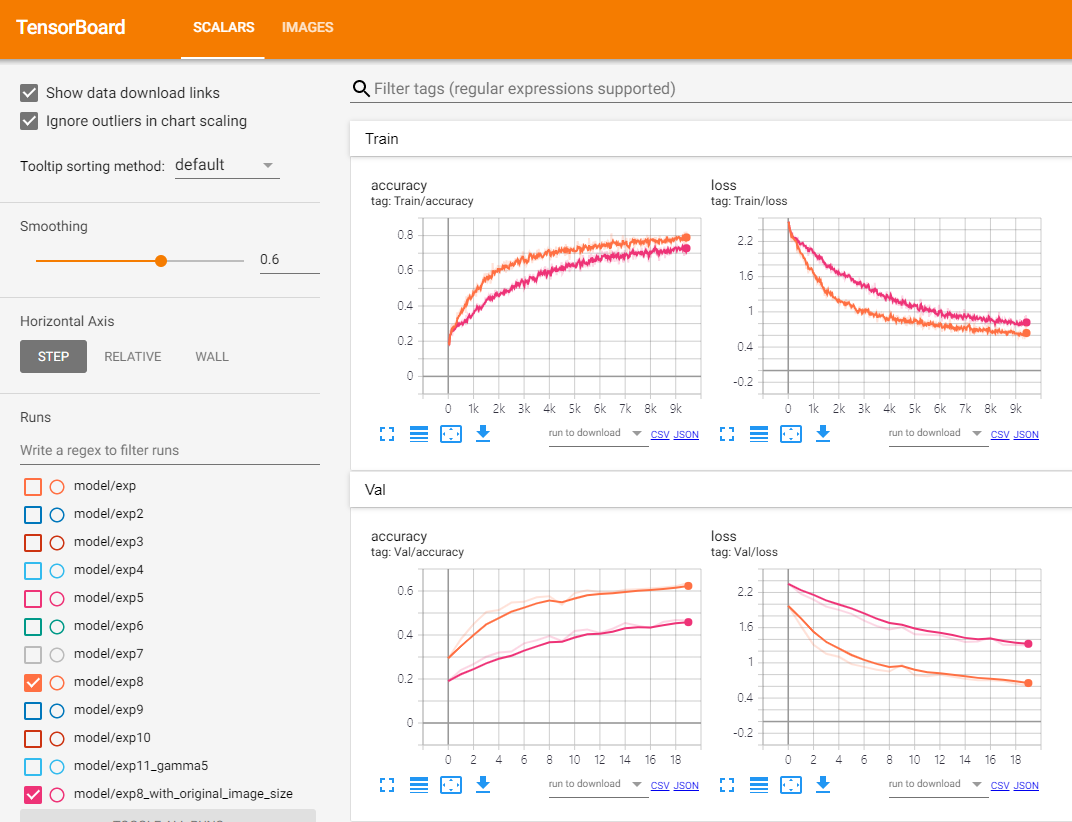

In [25]:
Image(filename="/opt/ml/base_code/results/v2_exp12.PNG")

**[변경사항]**
- 비교군: exp8, exp12
- exp 8 setup에서 image size를 두 배로 늘려주었음.

**[결과]**
- 성능이 상당히 많이 떨어졌음.

**[분석]**
- 입력 데이터의 크기는 커졌는데, 이를 소화할 수 있을 정도의 아키텍처가 갖춰지지 않아서 성능이 나오지 않는 것 같음.
- 입력 이미지 사이즈가 무조건 크다고 좋은 것은 아니겠지만, 일단 이미지 사이즈가 크면 활용할 수 있는 정보의 양이 많기 때문에
이를 소화할 수 있는 아키텍처를 구성한다면 이미지 사이즈가 작은 것보다 큰 것이 좋은 성능과 연결될 것이라고 생각함.

**[계획]**
- 아키텍처 변경 이후 다양한 실험 진행